In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io

In [2]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name = fn, length = len(uploaded[fn])))

Saving Dow Jones.csv to Dow Jones.csv
User uploaded file "Dow Jones.csv" with length 413323 bytes


In [0]:
df = pd.read_csv("Dow Jones.csv")

#df = pd.read_csv("Crude Oil.csv")

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-04-05,10246.0,10340.0,10222.0,10290.0,10290.0,2339.0
1,2002-04-07,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-04-08,10277.0,10280.0,10105.0,10268.0,10268.0,4234.0
3,2002-04-09,10290.0,10311.0,10205.0,10222.0,10222.0,4407.0
4,2002-04-10,10229.0,10399.0,10215.0,10383.0,10383.0,6189.0


In [5]:
print(df.shape)

(5555, 7)


In [8]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [0]:
# Fill NAN or null value 

#df["Open"].fillna( method ='ffill', inplace = True)
#df["High"].fillna( method ='ffill', inplace = True)
#df["Low"].fillna( method ='ffill', inplace = True)
#df["Close"].fillna( method ='ffill', inplace = True)
#df["Adj Close"].fillna( method ='ffill', inplace = True)
#df["Volume"].fillna( method ='ffill', inplace = True)


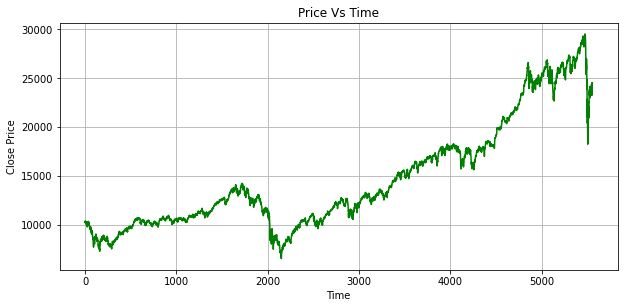

In [9]:
f, axs = plt.subplots(1, 1, figsize = (10, 10))

close_price = df["Close"]
Date = df['Date']

plt.subplot(212)
plt.grid(True)

plt.xlabel('Time')
plt.ylabel("Close Price")
plt.title('Price Vs Time')

plt.plot(close_price, 'g')

In [0]:
company_close = df.Close.values.astype('float32')
company_close = company_close.reshape(-1, 1)
closing_stock = company_close

In [11]:
closing_stock[: , 0]

array([10290., 10290., 10268., ..., 24531., 24218., 24489.], dtype=float32)

In [12]:
stocks = closing_stock[: , 0]
print(stocks)
stocks = stocks.reshape(len(stocks) , 1)

[10290. 10290. 10268. ... 24531. 24218. 24489.]


In [0]:
#Feature scaling the vector for better model performance.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
stocks = scaler.fit_transform(stocks)

In [0]:
train = int(len(stocks) * 0.80)
test = len(stocks) - train

In [15]:
print(train, test)

4444 1111


In [16]:
train = stocks[ 0 : train]
print(train)

[[0.16360077]
 [0.16360077]
 [0.16264406]
 ...
 [0.5061796 ]
 [0.5011524 ]
 [0.50093496]]


In [0]:
test = stocks[len(train) : ]

In [0]:
train = train.reshape(len(train) , 1)
test = test.reshape(len(test) , 1)

In [19]:
print(train.shape , test.shape)

(4444, 1) (1111, 1)


In [0]:
# Process_data for the required input for LSTM.

def process_data(data , n_features):
    dataX, dataY = [], []
    for i in range(len(data) - n_features - 1):
        a = data[i : (i + n_features), 0]
        dataX.append(a)
        dataY.append(data[i + n_features, 0])
    return np.array(dataX), np.array(dataY)

In [0]:
#Here I am taking 2 past values to predict a single value. This has already been checked and optimized after taking several cases.

n_features = 2

trainX, trainY = process_data(train, n_features)
testX, testY = process_data(test, n_features)

In [22]:
print(trainX.shape , trainY.shape , testX.shape , testY.shape)

(4441, 2) (4441,) (1108, 2) (1108,)


In [0]:
#Reshaping again for required LSTM input as (sample , timestamp , features per sample).

#Here I am taking timestamp as 1.

trainX = trainX.reshape(trainX.shape[0] , 1 ,trainX.shape[1])
testX = testX.reshape(testX.shape[0] , 1 ,testX.shape[1])

In [24]:
import math

from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation
from keras.layers import LSTM , GRU
from keras.optimizers import Adam , SGD , RMSprop

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [25]:
#Checkpointing the model when required and using other callbacks.

filepath="stock_weights.hdf5"
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [26]:
# Build Model

model = Sequential()
model.add(GRU(512, input_shape = (1 , n_features) , return_sequences = True)) # previous 256
model.add(Dropout(0.4))
model.add(LSTM(512))                # previous 256
model.add(Dropout(0.4))
model.add(Dense(128, activation = 'relu')) # previous 64
model.add(Dense(1))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 512)            791040    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,956,033
Trainable params: 2,956,033
Non-trainable params: 0
____________________________________________

In [0]:
# Compile Model

model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = 0.0005), metrics = ['mean_squared_error'])


In [29]:
# Run Model

history = model.fit(trainX, trainY, epochs = 100 , batch_size = 32, 
          callbacks = [checkpoint , lr_reduce] , validation_data = (testX, testY))

Train on 4441 samples, validate on 1108 samples
Epoch 1/100
4441/4441 [==============================] - 12s 3ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 2.2363e-04 - val_mean_squared_error: 2.2363e-04

Epoch 00001: val_loss improved from -inf to 0.00022, saving model to stock_weights.hdf5
Epoch 2/100
4441/4441 [==============================] - 10s 2ms/step - loss: 2.6899e-04 - mean_squared_error: 2.6899e-04 - val_loss: 3.6779e-04 - val_mean_squared_error: 3.6779e-04

Epoch 00002: val_loss improved from 0.00022 to 0.00037, saving model to stock_weights.hdf5

Epoch 00002: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 3/100
4441/4441 [==============================] - 10s 2ms/step - loss: 2.4127e-04 - mean_squared_error: 2.4127e-04 - val_loss: 1.7578e-04 - val_mean_squared_error: 1.7578e-04

Epoch 00003: val_loss did not improve from 0.00037

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.
Epoch 4/100
4441/4

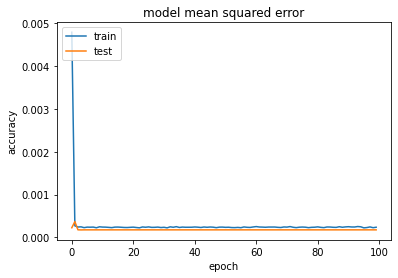

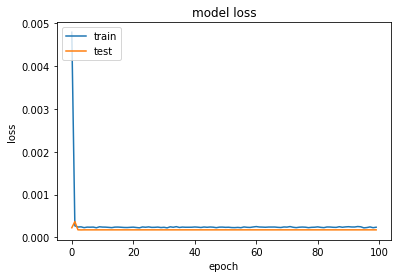

In [30]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
# The mean square error for validation set is 0.000174 which is very low and good as well.

def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

    return trainScore[0], testScore[0]

model_score(model, trainX, trainY , testX, testY)

Train Score: 0.00003 MSE (0.01 RMSE)
Test Score: 0.00017 MSE (0.01 RMSE)


(3.084461857479474e-05, 0.0001747916221016823)

In [32]:
# Inverse transforming the scaled vector earlier and checking for the error visually in the graph

pred = model.predict(testX)
pred = scaler.inverse_transform(pred)
pred[:10]

array([[18225.658],
       [18209.014],
       [18155.643],
       [18064.74 ],
       [18043.14 ],
       [18155.463],
       [18131.107],
       [18125.086],
       [18184.82 ],
       [18152.277]], dtype=float32)

In [33]:
testY = testY.reshape(testY.shape[0] , 1)
testY = scaler.inverse_transform(testY)
testY[:10]

array([[18190.],
       [18190.],
       [18014.],
       [18139.],
       [18238.],
       [18097.],
       [18219.],
       [18219.],
       [18156.],
       [18092.]], dtype=float32)

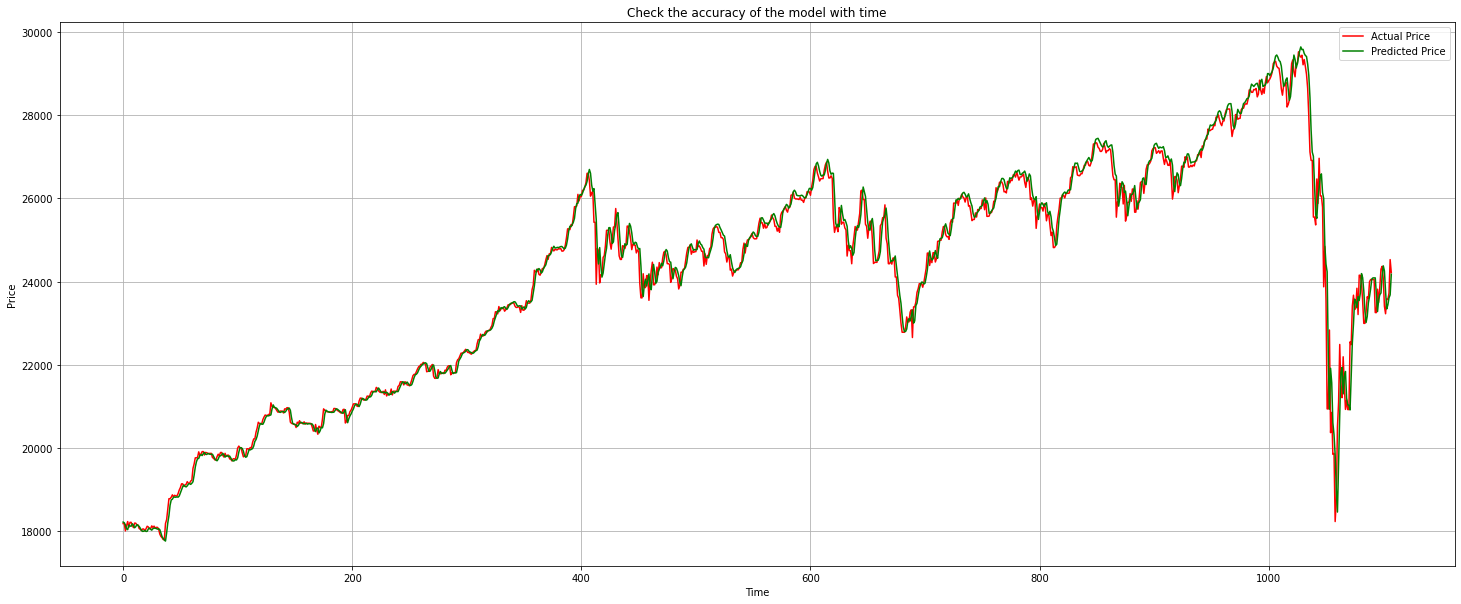

In [34]:
# The space between the predicted (red) and actual (blue) line is self explanatory for the model tuning and performance.

plt.rcParams["figure.figsize"] = (25, 10)
plt.plot(testY , 'r', label = 'Actual Price')
plt.plot(pred , 'g', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Check the accuracy of the model with time')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
testY[-10 : ]

array([[24301.998],
       [24369.   ],
       [24076.   ],
       [23412.   ],
       [23230.   ],
       [23588.   ],
       [23574.   ],
       [23722.998],
       [24531.   ],
       [24218.   ]], dtype=float32)

In [38]:
pred[-10 : ]

array([[23728.9  ],
       [24136.29 ],
       [24381.135],
       [24261.18 ],
       [23768.92 ],
       [23344.965],
       [23441.715],
       [23611.736],
       [23682.607],
       [24178.605]], dtype=float32)